In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import load_wine
from AdjustedRandomForest import train, train2
from mislabelling import symmetric_noise, pair_noise

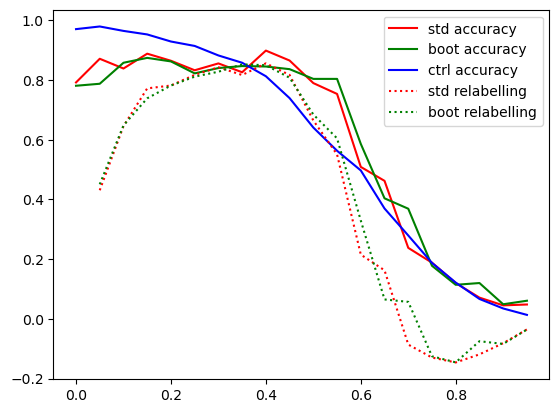

In [ ]:
RESOLUTION = 20
TRIALS = 30
N_ESTIMATORS = 10
TEST_SIZE = 0.25

accuracies = [[0 for _ in range(RESOLUTION)] for _ in range(3)]
mislabelling = [[0 for _ in range(RESOLUTION)] for _ in range(3)]
wine = load_wine()

for i in range(RESOLUTION):
    for _ in range(TRIALS):
        X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=TEST_SIZE)

        y_mislabelled = np.copy(y_train)
        y_mislabelled = symmetric_noise(y_mislabelled, 0 + i * 1/RESOLUTION)

        rf, corrected_y = train(RandomForestClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=N_ESTIMATORS)
        y_pred = rf.predict(X_test)
        mislabelling[0][i] += (sum(i!=j for i, j in zip(corrected_y, y_train)))
        accuracies[0][i] += (metrics.accuracy_score(y_test, y_pred))

        rf, corrected_y = train(RandomForestClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=N_ESTIMATORS, bootstrapping=True)
        y_pred = rf.predict(X_test)
        mislabelling[1][i] += (sum(i!=j for i, j in zip(corrected_y, y_train)))
        accuracies[1][i] += (metrics.accuracy_score(y_test, y_pred))

        rf = RandomForestClassifier(n_estimators=N_ESTIMATORS*5, criterion='entropy')
        rf.fit(X_train, y_mislabelled)
        y_pred = rf.predict(X_test)
        accuracies[2][i] += (metrics.accuracy_score(y_test, y_pred))

accuracies =  np.array(accuracies) / TRIALS
mislabelling =  np.array(mislabelling) / TRIALS

n_samples = len(wine.target) * (1 - TEST_SIZE)

for i in range(1, RESOLUTION):
    for j in range(3):
        mislabelling[j][i] /= n_samples * (0 + 1/RESOLUTION * i)
    
mislabelling = 1 - mislabelling

x_axis = [0 + 1/RESOLUTION * i for i in range(RESOLUTION)]

plt.plot(x_axis, accuracies[0], label = "std accuracy", linestyle = "-", color = "red")
plt.plot(x_axis, accuracies[1], label = "boot accuracy", linestyle = "-", color = "green")
plt.plot(x_axis, accuracies[2], label = "ctrl accuracy", linestyle = "-", color = "blue")
plt.plot(x_axis[1:], mislabelling[0][1:], label = "std relabelling", linestyle = ":", color = "red")
plt.plot(x_axis[1:], mislabelling[1][1:], label = "boot relabelling", linestyle = ":", color = "green")
plt.legend()
plt.show()

# Is accuracy about 50% of data at no mislabelling
# Does evaluating off n trees make any difference?

In [10]:
# MISLABELLING
scores_my = []
mismatched_my = []
scores_my_2 = []
mismatched_my_2 = []
scores_std = []
MISLABELLING = 0.4

for _ in range(100):
    wine = load_wine()
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target)

    y_mislabelled = np.copy(y_train)
    
    '''
    n_classes = len(set(y_mislabelled))
    for i in range(int(len(y_mislabelled) * MISLABELLING)):
        y_mislabelled[i] = (y_mislabelled[i] + random.randint(1, n_classes-1)) % n_classes
    '''
    y_mislabelled = pair_noise(y_mislabelled, MISLABELLING)

    rf, corrected_y = train(ExtraTreesClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=10)
    y_test_pred = rf.predict(X_test)
    #mismatch_indices = [index for index, (i, j) in enumerate(zip(corrected_y, y_train)) if i != j]
    mismatched_my.append(sum(i!=j for i, j in zip(corrected_y, y_train)))
    scores_my.append(metrics.accuracy_score(y_test, y_test_pred))

    rf, corrected_y = train(ExtraTreesClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=10, bootstrapping=True)
    y_test_pred = rf.predict(X_test)
    #mismatch_indices = [index for index, (i, j) in enumerate(zip(corrected_y, y_train)) if i != j]
    mismatched_my_2.append(sum(i!=j for i, j in zip(corrected_y, y_train)))
    scores_my_2.append(metrics.accuracy_score(y_test, y_test_pred))

    rf = ExtraTreesClassifier(n_estimators=50, criterion='entropy')
    rf.fit(X_train, y_mislabelled)
    y_test_pred = rf.predict(X_test)
    scores_std.append(metrics.accuracy_score(y_test, y_test_pred))

mismatched_init = int(len(X_train) * MISLABELLING)

print(f"\nTest Average Accuracy: {(np.mean(scores_my)*100).round(2)}%")
print(f"Labels Corrected: {((1 - np.mean(mismatched_my)/mismatched_init) * 100).round(2)}%")

print(f"\nTest 2 Average Accuracy: {(np.mean(scores_my_2)*100).round(2)}%")
print(f"Labels Corrected: {((1 - np.mean(mismatched_my_2)/mismatched_init) * 100).round(2)}%")

print(f"\nControl Average Accuracy: {(np.mean(scores_std)*100).round(2)}%")

# Is accuracy about 50% of data at no mislabelling
# Does evaluating off n trees make any difference?


Test Average Accuracy: 77.24%
Labels Corrected: 65.74%

Test 2 Average Accuracy: 64.91%
Labels Corrected: 0.74%

Control Average Accuracy: 69.91%


In [11]:
# MISLABELLING
scores_my = []
mismatched_my = []
scores_my_2 = []
mismatched_my_2 = []
scores_std = []
MISLABELLING = 0.4

for _ in range(100):
    wine = load_wine()
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target)

    y_mislabelled = np.copy(y_train)
    
    '''
    n_classes = len(set(y_mislabelled))
    for i in range(int(len(y_mislabelled) * MISLABELLING)):
        y_mislabelled[i] = (y_mislabelled[i] + random.randint(1, n_classes-1)) % n_classes
    '''
    y_mislabelled = pair_noise(y_mislabelled, [MISLABELLING, MISLABELLING-0.3, MISLABELLING+0.1])

    rf, corrected_y = train(ExtraTreesClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=10)
    y_test_pred = rf.predict(X_test)
    #mismatch_indices = [index for index, (i, j) in enumerate(zip(corrected_y, y_train)) if i != j]
    mismatched_my.append(sum(i!=j for i, j in zip(corrected_y, y_train)))
    scores_my.append(metrics.accuracy_score(y_test, y_test_pred))

    rf, corrected_y = train2(ExtraTreesClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=10)
    y_test_pred = rf.predict(X_test)
    #mismatch_indices = [index for index, (i, j) in enumerate(zip(corrected_y, y_train)) if i != j]
    mismatched_my_2.append(sum(i!=j for i, j in zip(corrected_y, y_train)))
    scores_my_2.append(metrics.accuracy_score(y_test, y_test_pred))

    rf = ExtraTreesClassifier(n_estimators=50, criterion='entropy')
    rf.fit(X_train, y_mislabelled)
    y_test_pred = rf.predict(X_test)
    scores_std.append(metrics.accuracy_score(y_test, y_test_pred))

mismatched_init = int(len(X_train) * MISLABELLING)

print(f"\nTest Average Accuracy: {(np.mean(scores_my)*100).round(2)}%")
print(f"Labels Corrected: {((1 - np.mean(mismatched_my)/mismatched_init) * 100).round(2)}%")

print(f"\nTest 2 Average Accuracy: {(np.mean(scores_my_2)*100).round(2)}%")
print(f"Labels Corrected: {((1 - np.mean(mismatched_my_2)/mismatched_init) * 100).round(2)}%")

print(f"\nControl Average Accuracy: {(np.mean(scores_std)*100).round(2)}%")

# Is accuracy about 50% of data at no mislabelling
# Does evaluating off n trees make any difference?

NameError: name 'train2' is not defined

In [ ]:
# MISLABELLING
scores_my = []
mismatched_my = []
scores_my_2 = []
mismatched_my_2 = []
scores_std = []
MISLABELLING = 0.5

for _ in range(100):
    wine = load_wine()
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target)

    y_mislabelled = np.copy(y_train)
    
    '''
    n_classes = len(set(y_mislabelled))
    for i in range(int(len(y_mislabelled) * MISLABELLING)):
        y_mislabelled[i] = (y_mislabelled[i] + random.randint(1, n_classes-1)) % n_classes
    '''
    y_mislabelled = symmetric_noise(y_mislabelled, MISLABELLING)

    rf, corrected_y = train(ExtraTreesClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=10)
    y_test_pred = rf.predict(X_test)
    #mismatch_indices = [index for index, (i, j) in enumerate(zip(corrected_y, y_train)) if i != j]
    mismatched_my.append(sum(i!=j for i, j in zip(corrected_y, y_train)))
    scores_my.append(metrics.accuracy_score(y_test, y_test_pred))

    rf, corrected_y = train2(ExtraTreesClassifier, X_train, y_mislabelled, np.unique(wine.target), n_estimators=10)
    y_test_pred = rf.predict(X_test)
    #mismatch_indices = [index for index, (i, j) in enumerate(zip(corrected_y, y_train)) if i != j]
    mismatched_my_2.append(sum(i!=j for i, j in zip(corrected_y, y_train)))
    scores_my_2.append(metrics.accuracy_score(y_test, y_test_pred))

    rf = ExtraTreesClassifier(n_estimators=50, criterion='entropy')
    rf.fit(X_train, y_mislabelled)
    y_test_pred = rf.predict(X_test)
    scores_std.append(metrics.accuracy_score(y_test, y_test_pred))

mismatched_init = int(len(X_train) * MISLABELLING)

print(f"\nTest Average Accuracy: {(np.mean(scores_my)*100).round(2)}%")
print(f"Labels Corrected: {((1 - np.mean(mismatched_my)/mismatched_init) * 100).round(2)}%")

print(f"\nTest 2 Average Accuracy: {(np.mean(scores_my_2)*100).round(2)}%")
print(f"Labels Corrected: {((1 - np.mean(mismatched_my_2)/mismatched_init) * 100).round(2)}%")

print(f"\nControl Average Accuracy: {(np.mean(scores_std)*100).round(2)}%")

# Is accuracy about 50% of data at no mislabelling
# Does evaluating off n trees make any difference?


Test Average Accuracy: 76.33%
Labels Corrected: 66.02%

Test 2 Average Accuracy: 58.38%
Labels Corrected: -0.64%

Control Average Accuracy: 66.13%
